In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense
from keras.utils import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Preprocess the images and labels
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image

## testing with just df_subdural to see how it goes
###### CNN without image data

In [1]:
df_subdural = pd.read_csv("SubduralHemorrhageRemovedFlags.csv")

NameError: name 'pd' is not defined

In [4]:
df_subdural = df_subdural.drop(['Unnamed: 0', 'Comments', 'Internal Notes'], axis=1)

In [5]:
df_subdural.head(5)

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement
0,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.45703125, ""y"": 0.78125}, {""x"": 0.4570...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092
1,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.404296875, ""y"": 0.333984375}, {""x"": 0...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092
2,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.521484375, ""y"": 0.83203125}, {""x"": 0....",2.0,NaN,NaN,0.157037
3,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.478515625, ""y"": 0.83984375}, {""x"": 0....",2.0,NaN,NaN,0.157037
4,1198353,ID_00eb6f7cc.jpg,https://go.centaurlabs.com/problem/1198353,Labeled,"['[{""x"": 0.48163298, ""y"": 0.71568763}, {""x"": 0...",15.0,5.0,"[{""x"": 0.447265625, ""y"": 0.73828125}, {""x"": 0....",1.0,"[[{'x': 0.447265625, 'y': 0.73828125}, {'x': 0...",0.00,0.306828


In [6]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_subdural['Origin'])
sequences = tokenizer.texts_to_sequences(df_subdural['Origin'])
X = pad_sequences(sequences, maxlen=max_len)

num_classes = len(np.unique(df_subdural['Labeling State']))
Y = pd.get_dummies(df_subdural['Labeling State']).values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [7]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(num_classes, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 328,386
Trainable params: 328,386
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
19/19 [==============================] - 2s 38ms/step - loss: 0.6829 - accuracy: 0.5717 - val_loss: 0.6485 - val_accuracy: 0.6533
Epoch 2/10
19/19 [==============================] - 0s 19ms/step - loss: 0.6727 - accuracy: 0.5883 - val_loss: 0.6496 - val_accuracy: 0.6533
Epoch 3/10
19/19 [==============================] - 0s 19ms/step - loss: 0.6646 - accuracy: 0.5883 - val_loss: 0.6436 - val_accuracy: 0.6533
Epoch 4/10
19/19 [==============================] - 0s 19ms/step - loss: 0.6473 - accuracy: 0.5883 - val_loss: 0.6324 - val_accuracy: 0.6533
Epoch 5/10
19/19 [==============================] - 0s 19ms/step - loss: 0.6111 - accuracy: 0.5950 - val_loss: 0.6033 - val_accuracy: 0.6733
Epoch 6/10
19/19 [==============================] - 0s 19ms/step - loss: 0.5350 - accuracy: 0.6983 - val_loss: 0.5535 - val_accuracy: 0.6867
Epoch 7/10
19/19 [==============================] - 0s 19ms/step - loss: 0.3919 - accuracy: 0.9433 - val_loss: 0.4760 - val_accuracy: 0.7933
Epoch 8/10
19

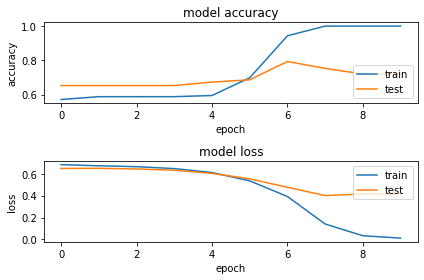

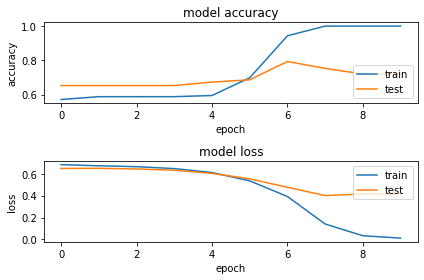

In [10]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

##### CNN with image data

In [11]:
image_directory = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\subdural\\subdural_window\\"
image_paths = [os.path.join(image_directory, img_name) for img_name in df_subdural['Origin']]

X = np.array([preprocess_image(img_path) for img_path in image_paths])
y = pd.get_dummies(df_subdural['Labeling State']).values #???

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
print()
print('Data loaded: train:',len(X_train),', test:',len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)


Data loaded: train: 600 , test: 150
X_train: (600, 224, 224, 3)
Y_train: (600, 2)


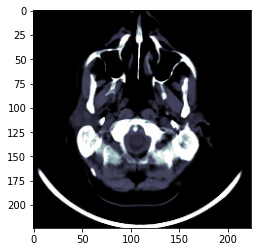

In [13]:
plt.imshow(X_train[0,:,:])

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
19/19 [==============================] - 19s 980ms/step - loss: 1.1306 - accuracy: 0.5600 - val_loss: 0.6809 - val_accuracy: 0.5733
Epoch 2/10
19/19 [==============================] - 19s 986ms/step - loss: 0.6761 - accuracy: 0.6083 - val_loss: 0.6821 - val_accuracy: 0.5733
Epoch 3/10
19/19 [==============================] - 19s 1s/step - loss: 0.6629 - accuracy: 0.6083 - val_loss: 0.6665 - val_accuracy: 0.6267
Epoch 4/10
19/19 [==============================] - 19s 988ms/step - loss: 0.6243 - accuracy: 0.6700 - val_loss: 0.6081 - val_accuracy: 0.6733
Epoch 5/10
19/19 [==============================] - 18s 969ms/step - loss: 0.5257 - accuracy: 0.7567 - val_loss: 0.5676 - val_accuracy: 0.7067
Epoch 6/10
19/19 [==============================] - 18s 970ms/step - loss: 0.4324 - accuracy: 0.8017 - val_loss: 0.4871 - val_accuracy: 0.7733
Epoch 7/10
19/19 [==============================] - 19s 989ms/step - loss: 0.3155 - accuracy: 0.8733 - val_loss: 0.5027 - val_accuracy: 0.7533
Ep

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

5/5 [==============================] - 1s 131ms/step - loss: 0.6682 - accuracy: 0.8133
Test loss: 0.6681803464889526, Test accuracy: 0.8133333325386047


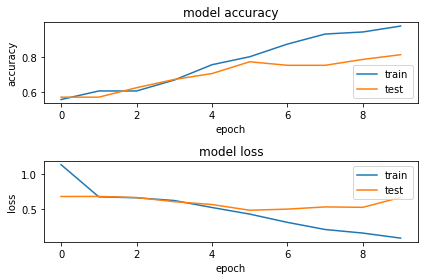

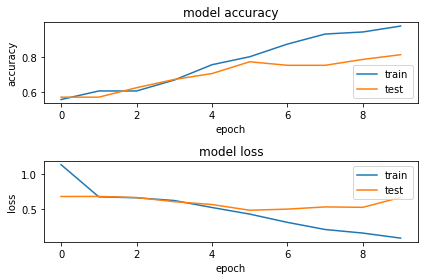

In [17]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## try with df_epidural

In [18]:
df_epidural = pd.read_csv("EpiduralHemorrhageRemovedFlags.csv")

In [19]:
image_directory = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\epidural\\subdural_window\\"
image_paths = [os.path.join(image_directory, img_name) for img_name in df_epidural['Origin']]

X = np.array([preprocess_image(img_path) for img_path in image_paths])
y = pd.get_dummies(df_epidural['Labeling State']).values

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [20]:
print()
print('Data loaded: train:',len(X_train),', test:',len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)


Data loaded: train: 365 , test: 122
X_train: (365, 224, 224, 3)
Y_train: (600, 2)


In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
12/12 [==============================] - 12s 968ms/step - loss: 1.4196 - accuracy: 0.4411 - val_loss: 1.1725 - val_accuracy: 0.5328
Epoch 2/10
12/12 [==============================] - 12s 969ms/step - loss: 1.0635 - accuracy: 0.5178 - val_loss: 1.0092 - val_accuracy: 0.5328
Epoch 3/10
12/12 [==============================] - 12s 978ms/step - loss: 0.9814 - accuracy: 0.5534 - val_loss: 1.0151 - val_accuracy: 0.5328
Epoch 4/10
12/12 [==============================] - 12s 967ms/step - loss: 0.9168 - accuracy: 0.5644 - val_loss: 1.0559 - val_accuracy: 0.4590
Epoch 5/10
12/12 [==============================] - 12s 973ms/step - loss: 0.8240 - accuracy: 0.6658 - val_loss: 1.0478 - val_accuracy: 0.4672
Epoch 6/10
12/12 [==============================] - 12s 1s/step - loss: 0.7026 - accuracy: 0.7151 - val_loss: 1.0878 - val_accuracy: 0.5082
Epoch 7/10
12/12 [==============================] - 12s 1s/step - loss: 0.5975 - accuracy: 0.7644 - val_loss: 1.1419 - val_accuracy: 0.5000
Epoch

In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

4/4 [==============================] - 1s 165ms/step - loss: 2.0362 - accuracy: 0.4426
Test loss: 2.036155939102173, Test accuracy: 0.44262295961380005


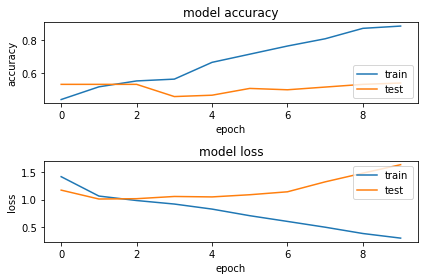

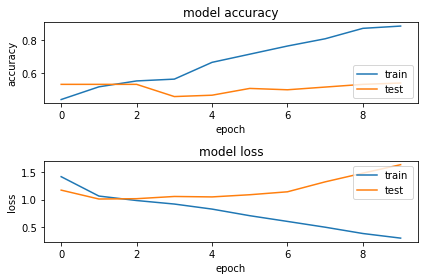

In [24]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## try with all all data merged
(Note: it broke my computer somehow LOL :v)

In [25]:
df_subdural = pd.read_csv("SubduralHemorrhageRemovedFlags.csv")
df_epidural = pd.read_csv("EpiduralHemorrhageRemovedFlags.csv")
df_intraparenchymal = pd.read_csv("IntraparenchymalHemorrhageRemovedFlags.csv")
df_subarachnoid = pd.read_csv("SubarachnoidHemorrhageRemovedFlags.csv")
df_multiple = pd.read_csv("MultipleHemorrhageRemovedFlags.csv")
df_intraventricular = pd.read_csv("IntraventricularHemorrhageRemovedFlags.csv")

In [26]:
df_epidural["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\epidural\\subdural_window\\" + df_epidural["Origin"]
df_subdural["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\subdural\\subdural_window\\" + df_subdural["Origin"]
df_intraparenchymal["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\intraparenchymal\\subdural_window\\" + df_intraparenchymal["Origin"]
df_subarachnoid["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\subarachnoid\\subdural_window\\" + df_subarachnoid["Origin"]
df_multiple["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\multi\\subdural_window\\" + df_multiple["Origin"]
df_intraventricular["Path"] = "D:\\MATH4570\\MatrixMethodsFinal\\XN_Project\\renders\\intraventricular\\subdural_window\\" + df_intraventricular["Origin"]

In [27]:
df_merged = pd.concat([df_subdural, df_epidural, df_intraparenchymal, df_subarachnoid, df_multiple, df_intraventricular])
df_merged.shape

(7119, 19)

In [28]:
df_merged = df_merged.drop(['Unnamed: 0', 'Comments', 'Internal Notes'], axis=1)

In [29]:
print(df_merged.shape)

(7119, 16)


In [30]:
df_merged = df_merged.drop_duplicates(subset=['Case ID'])

In [31]:
print(df_merged.shape)

(4501, 16)


##### CNN without image data

In [32]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_merged['Origin'])
sequences = tokenizer.texts_to_sequences(df_merged['Origin'])
X = pad_sequences(sequences, maxlen=max_len)

num_classes = len(np.unique(df_merged['Labeling State']))
Y = pd.get_dummies(df_merged['Labeling State']).values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
113/113 [==============================] - 4s 21ms/step - loss: 1.2598 - accuracy: 0.4533 - val_loss: 1.1503 - val_accuracy: 0.4850
Epoch 2/5
113/113 [==============================] - 2s 18ms/step - loss: 1.1441 - accuracy: 0.4606 - val_loss: 1.1533 - val_accuracy: 0.4850
Epoch 3/5
113/113 [==============================] - 2s 18ms/step - loss: 1.1213 - accuracy: 0.4606 - val_loss: 1.1474 - val_accuracy: 0.4850
Epoch 4/5
113/113 [==============================] - 2s 18ms/step - loss: 0.9570 - accuracy: 0.5597 - val_loss: 1.1604 - val_accuracy: 0.4806
Epoch 5/5
113/113 [==============================] - 2s 18ms/step - loss: 0.5171 - accuracy: 0.7944 - val_loss: 1.2339 - val_accuracy: 0.4562


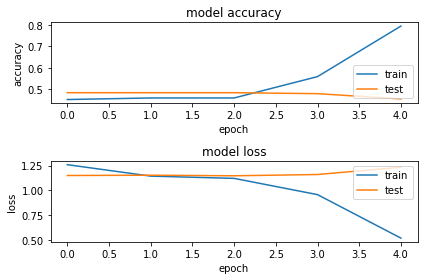

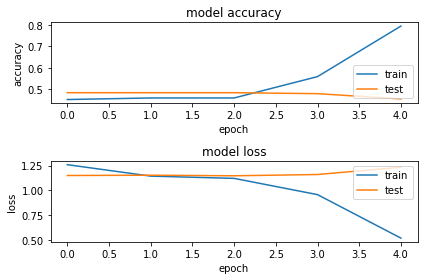

In [33]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

##### CNN with image data for merged data

In [45]:
image_paths = [os.path.join("", img_name) for img_name in df_merged['Path']]

X = np.array([preprocess_image(img_path) for img_path in image_paths])
y = pd.get_dummies(df_merged['Labeling State']).values

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [46]:
print()
print('Data loaded: train:',len(X_train),', test:',len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)


Data loaded: train: 2700 , test: 901
X_train: (2700, 224, 224, 3)
Y_train: (2700, 5)
X_test: (901, 224, 224, 3)
y_test: (901, 5)


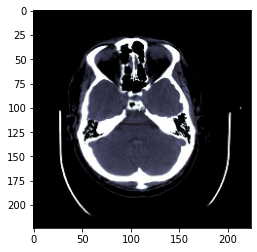

In [47]:
plt.imshow(X_train[10,:,:])

In [48]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)     

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# X_train = X_train[:2700]
# Y_train = Y_train[:2700]
# X_val = X_val[:2700]
# Y_val = Y_val[:2700]
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=128,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
22/22 [==============================] - 85s 4s/step - loss: 1.1553 - accuracy: 0.4470 - val_loss: 1.1381 - val_accuracy: 0.4811
Epoch 2/10
22/22 [==============================] - 76s 3s/step - loss: 1.1275 - accuracy: 0.4607 - val_loss: 1.1547 - val_accuracy: 0.4556
Epoch 3/10
22/22 [==============================] - 77s 3s/step - loss: 1.1034 - accuracy: 0.4785 - val_loss: 1.1811 - val_accuracy: 0.4478
Epoch 4/10
22/22 [==============================] - 78s 4s/step - loss: 1.0222 - accuracy: 0.5396 - val_loss: 1.2374 - val_accuracy: 0.3767
Epoch 5/10
22/22 [==============================] - 79s 4s/step - loss: 0.8959 - accuracy: 0.6096 - val_loss: 1.4339 - val_accuracy: 0.3922
Epoch 6/10
22/22 [==============================] - 78s 4s/step - loss: 0.6824 - accuracy: 0.7063 - val_loss: 1.6763 - val_accuracy: 0.3600
Epoch 7/10
22/22 [==============================] - 79s 4s/step - loss: 0.4927 - accuracy: 0.8022 - val_loss: 2.1369 - val_accuracy: 0.3267
Epoch 8/10
22/22 [==

In [51]:
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

29/29 [==============================] - 7s 231ms/step - loss: 3.1539 - accuracy: 0.3378
Test loss: 3.1538901329040527, Test accuracy: 0.3377777636051178


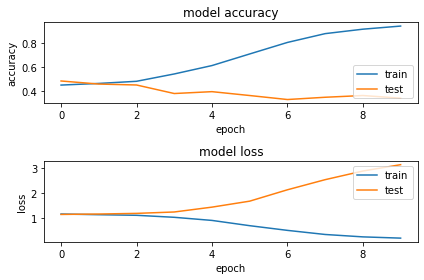

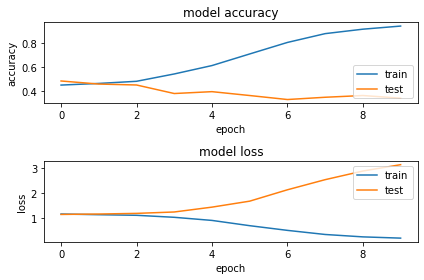

In [52]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (512, 512, 3)

# Define the number of classes
num_classes = 6

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])